In [1]:
! pip install seaborn numba

In [2]:
!date

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter

%matplotlib inline

Tue Jul 11 08:17:31 PM SAST 2023


In [3]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

In [5]:
# load data from csv file
try:
    df_all = pd.read_csv("data/rugby.csv", index_col=0)
except:
    df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

Goals of exercise (can be found on https://www.pymc.io/projects/examples/en/latest/case_studies/rugby_analytics.html#motivation)
-Infer strength of teams based on the scorelines, although it is a noisy measure of strength, latent parameter might provide insight.

## Visualization

In [8]:
df_all.describe()

,home_score,away_score,year
count,60.000000,60.000000,60.000000
mean,23.500000,19.983333,2015.500000
std,14.019962,12.911028,1.127469
min,0.000000,0.000000,2014.000000
25%,16.000000,10.000000,2014.750000
50%,20.500000,18.000000,2015.500000
75%,27.250000,23.250000,2016.250000
max,67.000000,63.000000,2017.000000


In [ ]:
def get_modes(df, feature_list,number_of_modes=2):
    mode_1_values = []
    mode_1_freq = []
    mode_2_values = []
    mode_2_freq = []
    for feature in feature_list:
        modes = df[feature].value_counts()[0:number_of_modes]
        if len(modes) > 1:
            mode_1_values.append(modes.index.values.tolist()[0])
            mode_1_freq.append(modes.values.tolist()[0])
            mode_2_values.append(modes.index.values.tolist()[1])
            mode_2_freq.append(modes.values.tolist()[1])
        else:
            mode_1_values.append(modes.index.values.tolist()[0])
            mode_1_freq.append(modes.values.tolist()[0])
            mode_2_values.append(None)
            mode_2_freq.append(None)
    return mode_1_values, mode_1_freq, mode_2_values, mode_2_freq#%%
! pip install seaborn numba

In [ ]:
!date

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor.tensor as pt
import seaborn as sns

from matplotlib.ticker import StrMethodFormatter

%matplotlib inline

In [ ]:
az.style.use("arviz-darkgrid")
plt.rcParams["figure.constrained_layout.use"] = False

In [ ]:
# load data from csv file
try:
    df_all = pd.read_csv("data/rugby.csv", index_col=0)
except:
    df_all = pd.read_csv(pm.get_data("rugby.csv"), index_col=0)

Goals of exercise (can be found on https://www.pymc.io/projects/examples/en/latest/case_studies/rugby_analytics.html#motivation)
-Infer strength of teams based on the scorelines, although it is a noisy measure of strength, latent parameter might provide insight.

## Visualization

In [10]:
def get_modes(df, feature_list,number_of_modes=2):
    mode_1_values = []
    mode_1_freq = []
    mode_2_values = []
    mode_2_freq = []
    for feature in feature_list:
        modes = df[feature].value_counts()[0:number_of_modes]
        if len(modes) > 1:
            mode_1_values.append(modes.index.values.tolist()[0])
            mode_1_freq.append(modes.values.tolist()[0])
            mode_2_values.append(modes.index.values.tolist()[1])
            mode_2_freq.append(modes.values.tolist()[1])
        else:
            mode_1_values.append(modes.index.values.tolist()[0])
            mode_1_freq.append(modes.values.tolist()[0])
            mode_2_values.append(None)
            mode_2_freq.append(None)
    return mode_1_values, mode_1_freq, mode_2_values, mode_2_freq

In [11]:
numeric_dqr = df_all.describe(include=np.number).T
numeric_dqr['missing_count'] = df_all.isna().sum()
numeric_dqr['%_missing'] = numeric_dqr['missing_count'] / df_all.count()[1]
numeric_dqr['Card.'] = df_all[numeric_dqr.T.columns.values.tolist()].nunique()
numeric_dqr[['count', '%_missing', 'Card.', 'min', '25%', 'mean', '50%', '75%', 'max', 'std']].rename(columns={'25%': '1st Qtr.', '50%': 'Median', '75%': '3rd Qtr.'})

,count,%_missing,Card.,min,1st Qtr.,mean,Median,3rd Qtr.,max,std
home_score,60.0,0.0,31,0.0,16.00,23.500000,20.5,27.25,67.0,14.019962
away_score,60.0,0.0,31,0.0,10.00,19.983333,18.0,23.25,63.0,12.911028
year,60.0,0.0,4,2014.0,2014.75,2015.500000,2015.5,2016.25,2017.0,1.127469


In [14]:
# Let's look at the tail end of this dataframe
df_all.tail()

,home_team,away_team,home_score,away_score,year
55,Italy,France,18,40,2017
56,England,Scotland,61,21,2017
57,Scotland,Italy,29,0,2017
58,France,Wales,20,18,2017
59,Ireland,England,13,9,2017


In [15]:
df_all["difference"] = np.abs(df_all["home_score"] - df_all["away_score"])

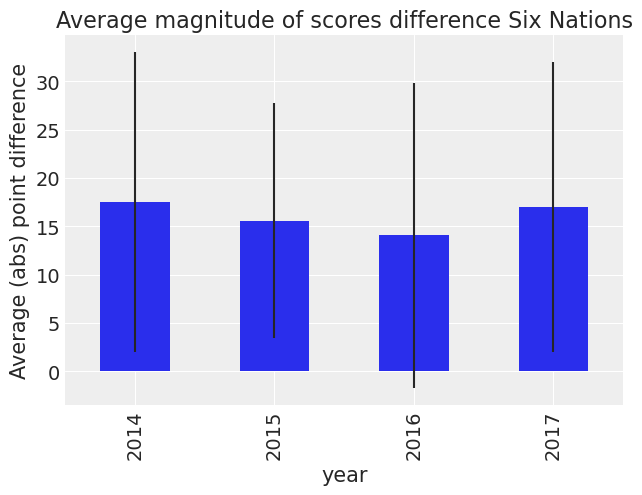

In [16]:
(
    df_all.groupby("year")["difference"]
    .mean()
    .plot(
        kind="bar",
        title="Average magnitude of scores difference Six Nations",
        yerr=df_all.groupby("year")["difference"].std(),
    )
    .set_ylabel("Average (abs) point difference")
);

In [17]:
df_all["difference_non_abs"] = df_all["home_score"] - df_all["away_score"]

In [18]:
df_all.pivot_table("difference_non_abs", "home_team", "year")

year,2014,2015,2016,2017
home_team,,,,
England,7.000000,20.666667,7.500000,21.333333
France,6.666667,0.000000,-2.333333,4.000000
Ireland,28.000000,8.500000,17.666667,7.000000
Italy,-21.000000,-31.000000,-23.500000,-33.666667
Scotland,-11.000000,-12.000000,2.500000,16.666667
Wales,25.666667,1.000000,22.000000,4.000000


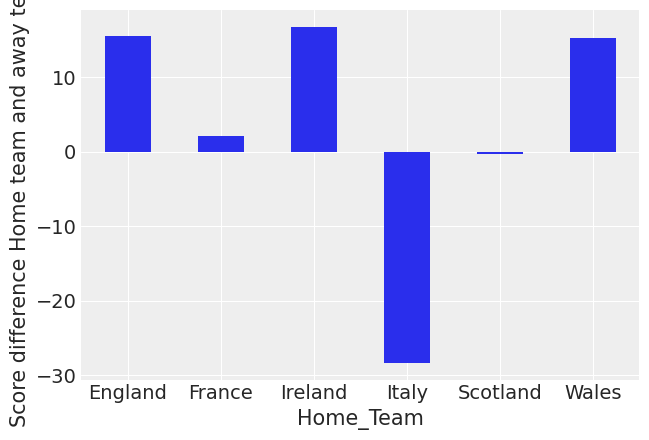

In [19]:
(
    df_all.pivot_table("difference_non_abs", "home_team")
    .rename_axis("Home_Team")
    .plot(kind="bar", rot=0, legend=False)
    .set_ylabel("Score difference Home team and away team")
);

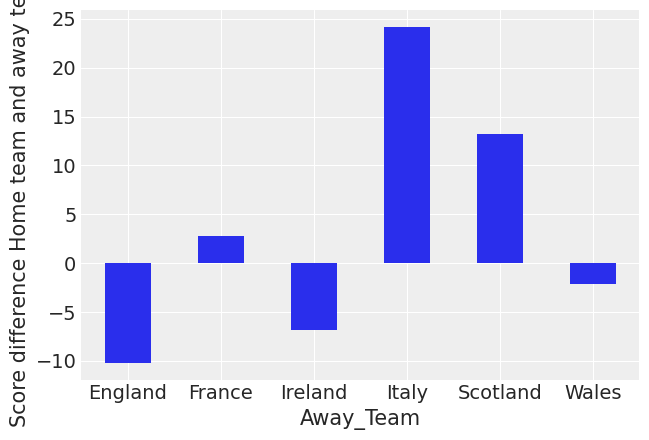

In [20]:
(
    df_all.pivot_table("difference_non_abs", "away_team")
    .rename_axis("Away_Team")
    .plot(kind="bar", rot=0, legend=False)
    .set_ylabel("Score difference Home team and away team")
);

/home/arneau/anaconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


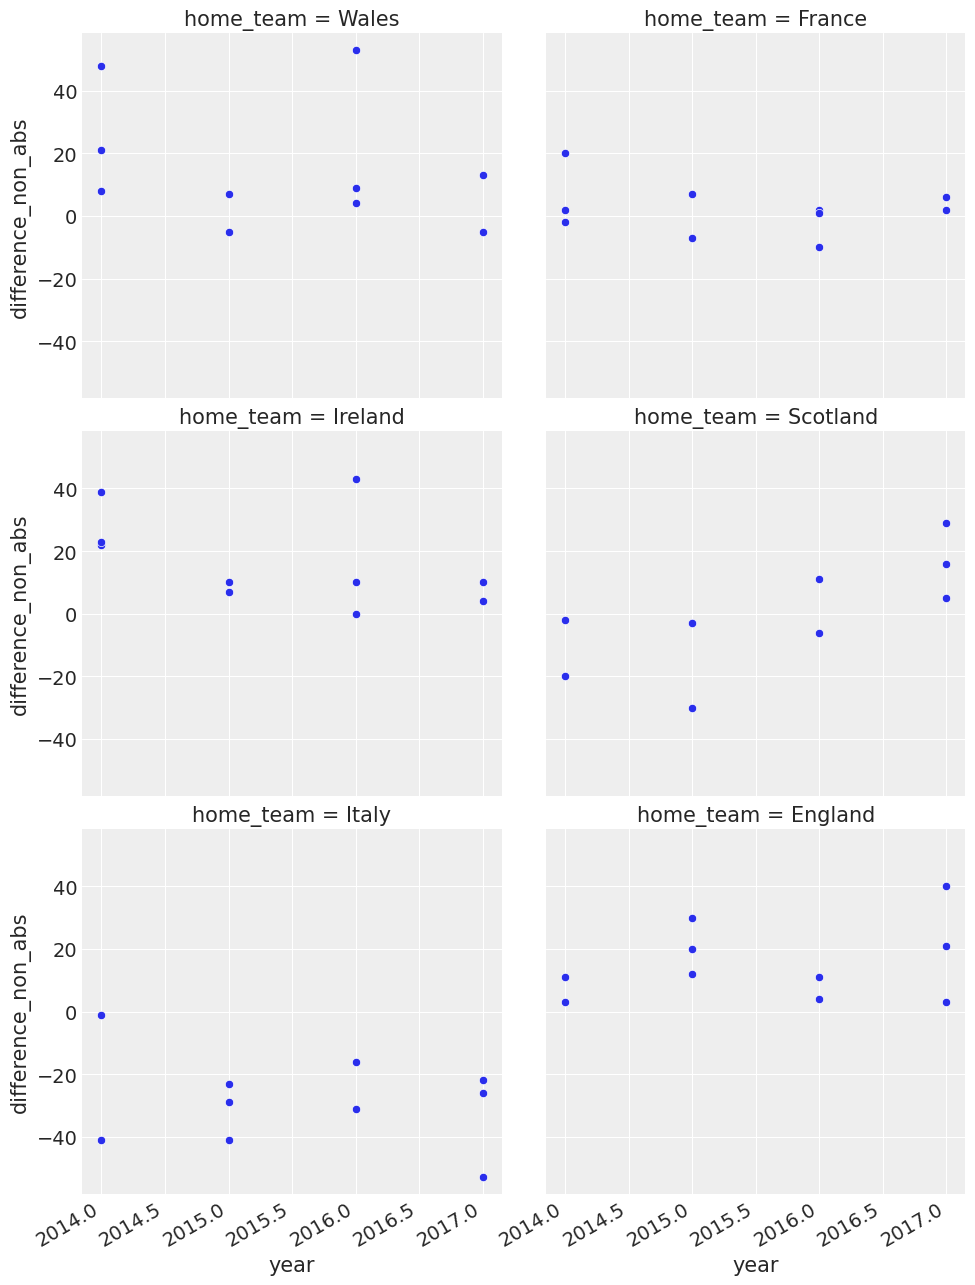

In [21]:
g = sns.FacetGrid(df_all, col="home_team", col_wrap=2, height=5)
g.map(sns.scatterplot, "year", "difference_non_abs")
g.fig.autofmt_xdate()

/home/arneau/anaconda3/envs/pymc_env/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


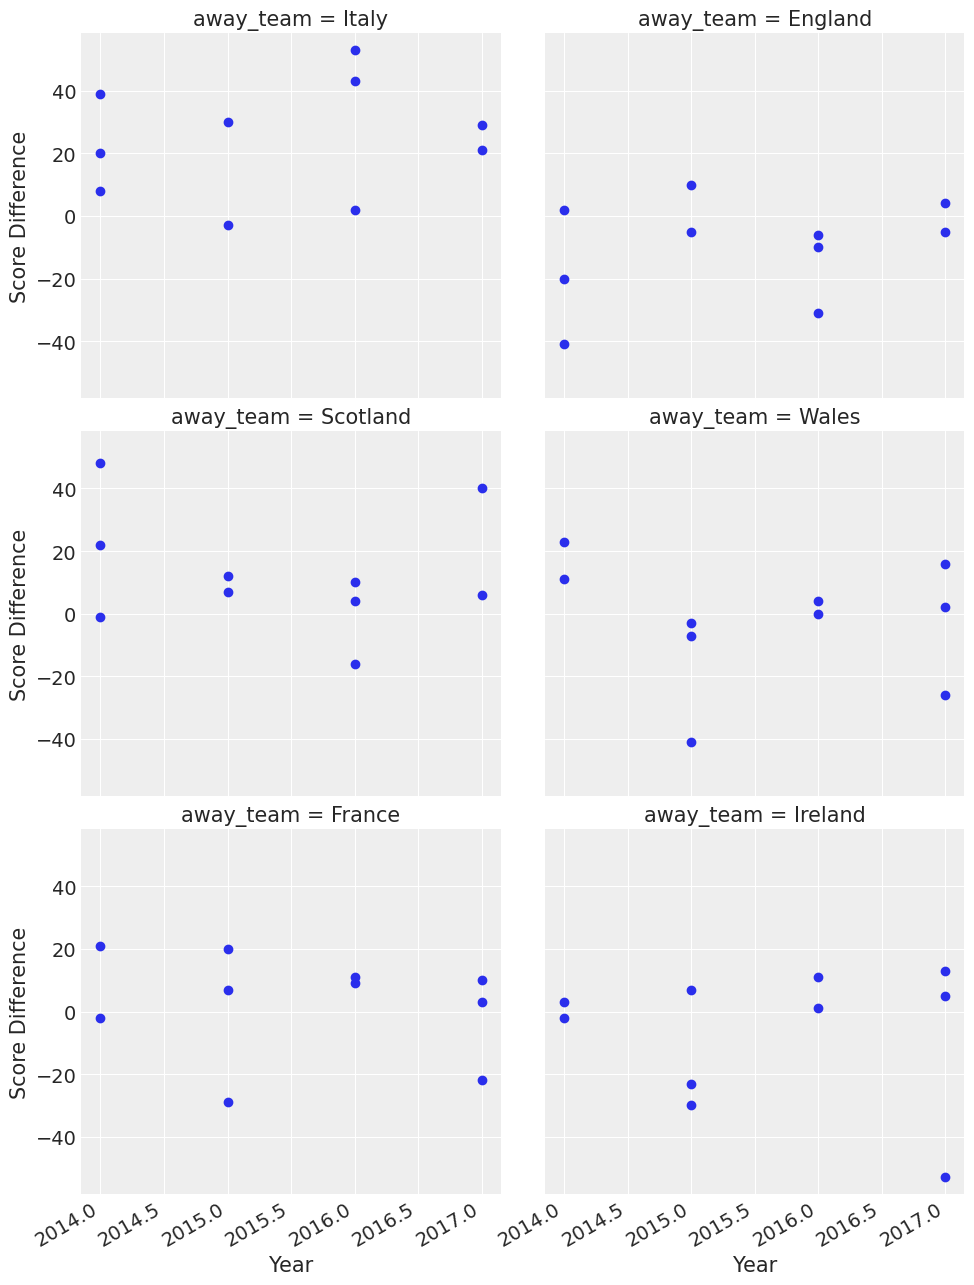

In [22]:
g = sns.FacetGrid(df_all, col="away_team", col_wrap=2, height=5)
g = g.map(plt.scatter, "year", "difference_non_abs").set_axis_labels("Year", "Score Difference")
g.fig.autofmt_xdate()